In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.calibration import CalibrationDisplay

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# глобальные переменные

SEED = 77

In [3]:
def create_metrics_report(data):
    
    y_true = data['target'].astype(int)

    # замеряем качество
    roc_auc = roc_auc_score(y_true, data['prediction'])

    # список для хранения результатов
    results = []

    # перебор порогов
    for cut_off in [0.4, 0.5, 0.6, 0.7, 0.8]:
        
        y_pred = (data['prediction'] > cut_off).astype(int)

        metrics = {
            'cut_off': cut_off,
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'TP': sum((y_pred == 1) & (y_true == 1)),
            'FP': sum((y_pred == 1) & (y_true == 0)),
            'TN': sum((y_pred == 0) & (y_true == 0)),
            'FN': sum((y_pred == 0) & (y_true == 1))
        }
        results.append(metrics)

    metrics_df = pd.DataFrame(results)
    metrics_df['roc_auc'] = roc_auc
    cols_order = ['cut_off', 'roc_auc', 'accuracy', 'precision', 'recall', 'f1', 'TP', 'FP', 'TN', 'FN']
    metrics_df = metrics_df[cols_order]

    return metrics_df.round(3)

In [4]:
df = pd.read_csv('donor_df_', sep=';')

In [5]:
cat_columns = df.select_dtypes(include=['object']).columns
num_columns = set(df.columns) - set(cat_columns)

assert len(cat_columns) + len(num_columns) == df.shape[1]

In [6]:
df['target'].value_counts()

1    91271
0    80589
Name: target, dtype: int64

In [7]:
df[cat_columns].describe()

,fund_id,gateway,country,region
count,171860,171860,171860,171860
unique,19,11,10,887
top,497b5be5c4c5bf0e9a6c3791c01476f5,mixplat,Россия,Москва
freq,111763,120537,154873,43458


In [8]:
# к айди фондов применим LabelEncoder

df['fund'] = LabelEncoder().fit_transform(df['fund_id'])
df = df.drop(columns=['fund_id'])
df.head()

# преобразуем оставшиеся категориальные колонки

for col in cat_columns:
    if col != 'fund_id': 
        if df[col].nunique() <= 11:
            one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)
        else:
            mean_target = df.groupby(col)['target'].mean()
            df[col] = df[col].map(mean_target)
            
            
df.head()    

,returned,multiple_country,russia,region,recurring,4_status,5_status,target,fund,gateway_YandexMerchantOcean,...,gateway_yandex,country_Великобритания,country_Германия,country_Европа,country_Неизвестно,country_Нидерланды,country_Россия,country_СНГ,country_США,country_Франция
0,0,0,0,0.648246,0,0.0,0.0,1,18,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0.833333,0,0.0,0.0,1,18,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0.559667,1,0.0,1.0,1,18,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0.648246,0,0.0,0.0,1,18,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0.648246,0,0.0,0.0,1,18,0,...,0,0,0,0,1,0,0,0,0,0


In [9]:
# оценка корреляции с таргетом

num_columns = list(num_columns)
num_columns.append('fund')
                   
df[num_columns].corr()

,returned,5_status,russia,recurring,4_status,multiple_country,target,fund
returned,1.000000,-0.000819,-0.015780,-0.012650,0.128931,-0.000424,-0.009943,0.011528
5_status,-0.000819,1.000000,0.025257,0.056071,0.000095,-0.003451,-0.057233,-0.007423
russia,-0.015780,0.025257,1.000000,0.347919,-0.007872,-0.008344,-0.102648,-0.185325
recurring,-0.012650,0.056071,0.347919,1.000000,-0.001744,-0.050008,-0.139159,-0.589567
4_status,0.128931,0.000095,-0.007872,-0.001744,1.000000,-0.000592,-0.012967,-0.008850
multiple_country,-0.000424,-0.003451,-0.008344,-0.050008,-0.000592,1.000000,0.020059,0.041611
target,-0.009943,-0.057233,-0.102648,-0.139159,-0.012967,0.020059,1.000000,0.282987
fund,0.011528,-0.007423,-0.185325,-0.589567,-0.008850,0.041611,0.282987,1.000000


In [10]:
# делим на X y

X = df.drop(columns=['target'])
y = df['target']

# инициализируем кросс-валидацию

kf = KFold(shuffle=True, random_state=SEED)
kf.get_n_splits(X)

5

In [11]:
xg_data = pd.DataFrame(index=X.index, columns=['prediction', 'target'])
dt_data = pd.DataFrame(index=X.index, columns=['prediction', 'target'])
rf_data = pd.DataFrame(index=X.index, columns=['prediction', 'target'])


for _, (train_index, test_index) in enumerate(kf.split(X)):
    
    xg = XGBClassifier(random_state=SEED).fit(X.loc[train_index], y.loc[train_index])
    xg_data.loc[test_index, 'prediction'] = xg.predict_proba(X.loc[test_index])[:, 1]
    xg_data.loc[test_index, 'target'] = y.loc[test_index]
    
    tree = DecisionTreeClassifier(random_state=SEED).fit(X.loc[train_index], y.loc[train_index])
    dt_data.loc[test_index, 'prediction'] = tree.predict_proba(X.loc[test_index])[:, 1]
    dt_data.loc[test_index, 'target'] = y.loc[test_index]
    
    forest = RandomForestClassifier(random_state=SEED).fit(X.loc[train_index], y.loc[train_index])
    rf_data.loc[test_index, 'prediction'] = forest.predict_proba(X.loc[test_index])[:, 1]
    rf_data.loc[test_index, 'target'] = y.loc[test_index]
    

xg_data['target'] = xg_data['target'].astype(int)
dt_data['target'] = dt_data['target'].astype(int)
rf_data['target'] = rf_data['target'].astype(int)

xg_data, dt_data, rf_data, 

(       prediction  target
 0        0.834805       1
 1        0.906162       1
 2         0.38853       1
 3        0.982666       1
 4        0.972463       1
 ...           ...     ...
 171855   0.739832       0
 171856   0.596154       0
 171857   0.739832       0
 171858   0.601527       0
 171859   0.870495       0
 
 [171860 rows x 2 columns],
        prediction  target
 0        0.832379       1
 1        0.885714       1
 2        0.392523       1
 3        0.998299       1
 4        0.996678       1
 ...           ...     ...
 171855   0.740127       0
 171856   0.587097       0
 171857   0.740127       0
 171858        1.0       0
 171859   0.879534       0
 
 [171860 rows x 2 columns],
        prediction  target
 0        0.830513       1
 1        0.885192       1
 2         0.39142       1
 3        0.998422       1
 4        0.996161       1
 ...           ...     ...
 171855    0.73866       0
 171856   0.584408       0
 171857    0.73866       0
 171858        1.0    

In [12]:
# XGBoost
create_metrics_report(xg_data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,0.784,0.646,0.609,0.927,0.735,84639,54285,26304,6632
1,0.5,0.784,0.699,0.857,0.519,0.647,47398,7932,72657,43873
2,0.6,0.784,0.697,0.879,0.498,0.635,45423,6273,74316,45848
3,0.7,0.784,0.689,0.900,0.467,0.615,42609,4744,75845,48662
4,0.8,0.784,0.671,0.923,0.414,0.572,37828,3134,77455,53443


In [13]:
# Решающее дерево
create_metrics_report(dt_data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,0.78,0.648,0.613,0.914,0.734,83406,52672,27917,7865
1,0.5,0.78,0.697,0.834,0.536,0.653,48962,9766,70823,42309
2,0.6,0.78,0.696,0.874,0.501,0.637,45716,6618,73971,45555
3,0.7,0.78,0.689,0.894,0.471,0.617,42986,5083,75506,48285
4,0.8,0.78,0.670,0.919,0.415,0.572,37895,3325,77264,53376


In [14]:
# Случайный лес
create_metrics_report(rf_data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,0.782,0.648,0.613,0.915,0.734,83469,52678,27911,7802
1,0.5,0.782,0.697,0.832,0.539,0.654,49155,9908,70681,42116
2,0.6,0.782,0.697,0.874,0.501,0.637,45687,6562,74027,45584
3,0.7,0.782,0.690,0.896,0.470,0.617,42913,4979,75610,48358
4,0.8,0.782,0.670,0.922,0.413,0.571,37697,3168,77421,53574


In [15]:
# у всех моделей низкий RECALL

In [16]:
final_df = pd.DataFrame({
           'xg_pred': xg_data['prediction'].astype(float),
           'dt_pred': dt_data['prediction'].astype(float),
           'rf_pred': rf_data['prediction'].astype(float),
           'target': y.values})
final_df

,xg_pred,dt_pred,rf_pred,target
0,0.834805,0.832379,0.830513,1
1,0.906162,0.885714,0.885192,1
2,0.388530,0.392523,0.391420,1
3,0.982666,0.998299,0.998422,1
4,0.972463,0.996678,0.996161,1
...,...,...,...,...
171855,0.739832,0.740127,0.738660,0
171856,0.596154,0.587097,0.584408,0
171857,0.739832,0.740127,0.738660,0
171858,0.601527,1.000000,1.000000,0


In [17]:
final_df[['xg_pred', 'dt_pred', 'rf_pred']].corr()

,xg_pred,dt_pred,rf_pred
xg_pred,1.000000,0.973801,0.983724
dt_pred,0.973801,1.000000,0.992687
rf_pred,0.983724,0.992687,1.000000


In [18]:
# корреляция очень высокая -> выбрать другие базовые алгоритмы / дообучить текущие

In [19]:
nb_data = pd.DataFrame(index=X.index, columns=['prediction', 'target'])
knn_data = pd.DataFrame(index=X.index, columns=['prediction', 'target'])

for _, (train_index, test_index) in enumerate(kf.split(X)):
    
    nb = GaussianNB().fit(X.loc[train_index], y.loc[train_index])
    nb_data.loc[test_index, 'prediction'] = nb.predict_proba(X.loc[test_index])[:, 1]
    nb_data.loc[test_index, 'target'] = y.loc[test_index]
    
    knn = KNeighborsClassifier().fit(X.loc[train_index], y.loc[train_index])
    knn_data.loc[test_index, 'prediction'] = knn.predict_proba(X.loc[test_index])[:, 1]
    knn_data.loc[test_index, 'target'] = y.loc[test_index]
    
nb_data['target'] = nb_data['target'].astype(int)
knn_data['target'] = knn_data['target'].astype(int)

In [20]:
# Байесовский классификатор
create_metrics_report(nb_data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,0.679,0.586,0.578,0.814,0.676,74313,54218,26371,16958
1,0.5,0.679,0.596,0.596,0.747,0.663,68138,46249,34340,23133
2,0.6,0.679,0.609,0.619,0.687,0.651,62691,38538,42051,28580
3,0.7,0.679,0.627,0.652,0.639,0.646,58344,31131,49458,32927
4,0.8,0.679,0.641,0.678,0.617,0.646,56340,26755,53834,34931


In [21]:
# KNN
create_metrics_report(knn_data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,0.657,0.636,0.609,0.877,0.719,80045,51284,29305,11226
1,0.5,0.657,0.636,0.609,0.877,0.719,80045,51284,29305,11226
2,0.6,0.657,0.596,0.619,0.624,0.621,56918,35037,45552,34353
3,0.7,0.657,0.596,0.619,0.624,0.621,56918,35037,45552,34353
4,0.8,0.657,0.596,0.661,0.490,0.563,44722,22915,57674,46549


In [22]:
final_df['nb_data'] = nb_data['prediction'].astype(float)
final_df['knn_data'] = knn_data['prediction'].astype(float)
final_df

,xg_pred,dt_pred,rf_pred,target,nb_data,knn_data
0,0.834805,0.832379,0.830513,1,1.000000,1.0
1,0.906162,0.885714,0.885192,1,1.000000,1.0
2,0.388530,0.392523,0.391420,1,0.999996,0.0
3,0.982666,0.998299,0.998422,1,1.000000,1.0
4,0.972463,0.996678,0.996161,1,1.000000,1.0
...,...,...,...,...,...,...
171855,0.739832,0.740127,0.738660,0,0.993756,1.0
171856,0.596154,0.587097,0.584408,0,0.999752,1.0
171857,0.739832,0.740127,0.738660,0,0.993756,1.0
171858,0.601527,1.000000,1.000000,0,0.644014,1.0


In [23]:
final_df.corr()

,xg_pred,dt_pred,rf_pred,target,nb_data,knn_data
xg_pred,1.000000,0.973801,0.983724,0.531446,0.505565,0.592546
dt_pred,0.973801,1.000000,0.992687,0.523992,0.486696,0.593513
rf_pred,0.983724,0.992687,1.000000,0.527958,0.493622,0.599710
target,0.531446,0.523992,0.527958,1.000000,0.265695,0.317314
nb_data,0.505565,0.486696,0.493622,0.265695,1.000000,0.116799
knn_data,0.592546,0.593513,0.599710,0.317314,0.116799,1.000000


In [24]:
# корреляция изменилась соответственно новые алгоритмы есть смысл брать в качестве базовых

In [25]:
final_df = final_df.rename(columns={'target':'t'})
final_df 

,xg_pred,dt_pred,rf_pred,t,nb_data,knn_data
0,0.834805,0.832379,0.830513,1,1.000000,1.0
1,0.906162,0.885714,0.885192,1,1.000000,1.0
2,0.388530,0.392523,0.391420,1,0.999996,0.0
3,0.982666,0.998299,0.998422,1,1.000000,1.0
4,0.972463,0.996678,0.996161,1,1.000000,1.0
...,...,...,...,...,...,...
171855,0.739832,0.740127,0.738660,0,0.993756,1.0
171856,0.596154,0.587097,0.584408,0,0.999752,1.0
171857,0.739832,0.740127,0.738660,0,0.993756,1.0
171858,0.601527,1.000000,1.000000,0,0.644014,1.0


In [26]:
# мета-модель пусть будет бустинг, в качестве третей базовой попробуем отдельно каждую из (дерево, лес)

# к исходному признаковому пространству добавим предсказания

final_df = final_df.rename({'target': 't'})
df = pd.concat([df, final_df], axis=1)

assert (df['target'] == df['t']).sum() == df.shape[0]

df = df.drop(columns=['t'])

In [27]:
# перемешаем данные перед обучением
final_df = final_df.sample(frac=1, random_state=SEED)
final_df = final_df.drop(columns=['xg_pred'])

# разделим на X y
X = final_df.drop(columns=['t'])
y = final_df['t']

# поделим на трейн тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# распределение классов в выборке в процентах
print(f"train target\n {y_train.value_counts(normalize=True).round(2) * 100}")
print(f"\ntest target\n {y_test.value_counts(normalize=True).round(2) * 100}")

train target
 1    53.0
0    47.0
Name: t, dtype: float64

test target
 1    53.0
0    47.0
Name: t, dtype: float64


accuracy: 0.695
precision: 0.827
recall: 0.542
f1: 0.655
confusion matrix:
 [[17464  2595]
 [10493 12413]]

roc_auc: 0.781


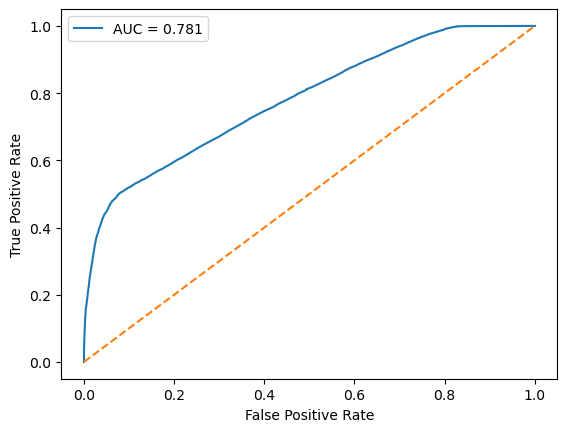

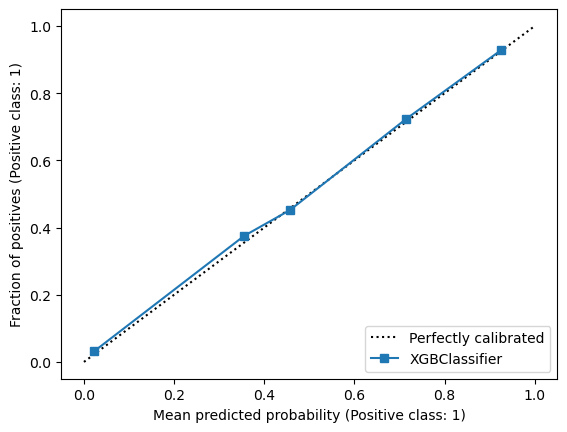

In [28]:
# обучим модель c предсказаниями базовой модели решающего дерева
model_1 = XGBClassifier(random_state=SEED, eval_metric='logloss')
model_1.fit(X_train.drop(columns=['rf_pred']), y_train)

# замерим качество на тесте
y_pred = model_1.predict(X_test.drop(columns=['rf_pred']))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"accuracy: {accuracy:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"f1: {f1:.3f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_matrix}")

y_proba = model_1.predict_proba(X_test.drop(columns=['rf_pred']))[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nroc_auc: {roc_auc:.3f}")

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

CalibrationDisplay.from_estimator(model_1, X_test.drop(columns=['rf_pred']), y_test)

In [29]:
data = pd.DataFrame()
data['target'] = y_test
data['prediction'] = model_1.predict_proba(X_test.drop(columns=['rf_pred']))[:, 1]

create_metrics_report(data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,0.781,0.652,0.620,0.897,0.734,20558,12584,7475,2348
1,0.5,0.781,0.695,0.827,0.542,0.655,12413,2595,17464,10493
2,0.6,0.781,0.697,0.879,0.501,0.638,11482,1578,18481,11424
3,0.7,0.781,0.689,0.903,0.467,0.615,10696,1154,18905,12210
4,0.8,0.781,0.665,0.929,0.403,0.562,9222,709,19350,13684


accuracy: 0.696
precision: 0.829
recall: 0.542
f1: 0.655
confusion matrix:
 [[17502  2557]
 [10502 12404]]

roc_auc: 0.782


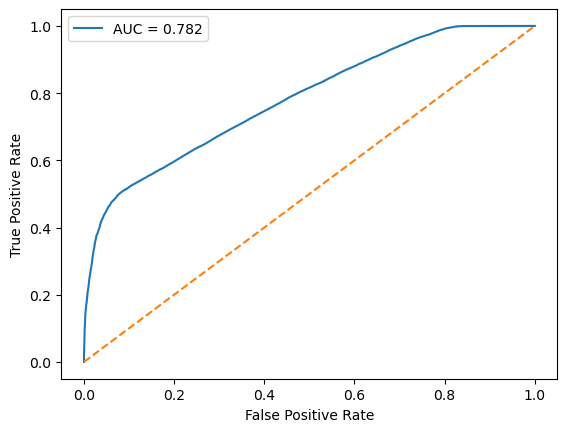

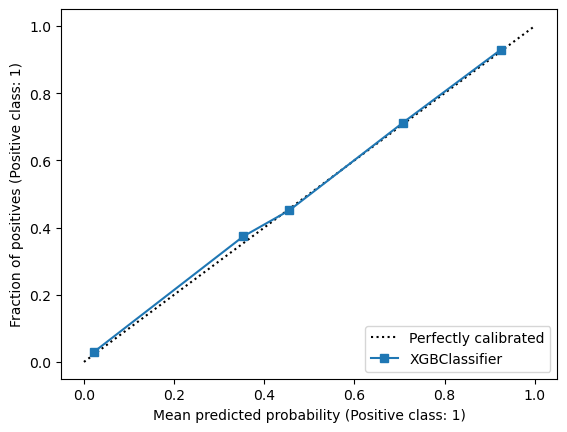

In [30]:
# обучим модель c предсказаниями базовой модели случайного леса

model_2 = XGBClassifier(random_state=SEED, eval_metric='logloss')
model_2.fit(X_train.drop(columns=['dt_pred']), y_train)

# замерим качество на тесте
y_pred = model_2.predict(X_test.drop(columns=['dt_pred']))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"accuracy: {accuracy:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"f1: {f1:.3f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_matrix}")

y_proba = model_2.predict_proba(X_test.drop(columns=['dt_pred']))[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nroc_auc: {roc_auc:.3f}")

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

CalibrationDisplay.from_estimator(model_2, X_test.drop(columns=['dt_pred']), y_test)

In [31]:
data = pd.DataFrame()
data['target'] = y_test
data['prediction'] = model_2.predict_proba(X_test.drop(columns=['dt_pred']))[:, 1]

create_metrics_report(data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,0.782,0.651,0.618,0.904,0.734,20696,12789,7270,2210
1,0.5,0.782,0.696,0.829,0.542,0.655,12404,2557,17502,10502
2,0.6,0.782,0.697,0.879,0.501,0.638,11476,1578,18481,11430
3,0.7,0.782,0.689,0.903,0.466,0.615,10673,1145,18914,12233
4,0.8,0.782,0.668,0.929,0.409,0.568,9362,720,19339,13544


In [32]:
# проверка исходного признакового пространства
df = df.sample(frac=1, random_state=SEED)

# разделим на X y
X_new = df.drop(columns=['xg_pred', 'dt_pred', 'rf_pred', 'nb_data', 'knn_data'])
y_new = df['target']

# поделим на трейн тест
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.25, random_state=SEED)

# распределение классов в выборке в процентах
print(f"train target\n {y_train.value_counts(normalize=True).round(2) * 100}")
print(f"\ntest target\n {y_test.value_counts(normalize=True).round(2) * 100}")

train target
 1    53.0
0    47.0
Name: target, dtype: float64

test target
 1    53.0
0    47.0
Name: target, dtype: float64


accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000
confusion matrix:
 [[20059     0]
 [    0 22906]]

roc_auc: 1.000


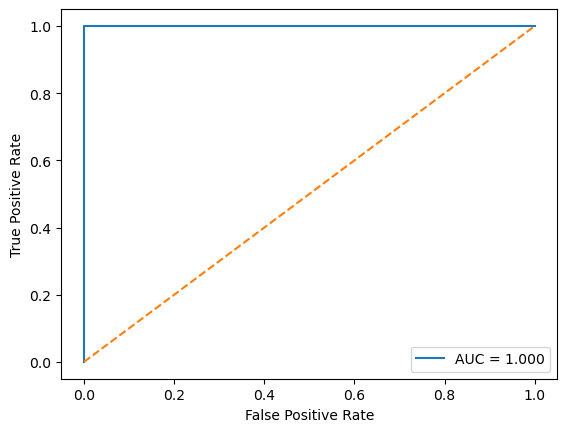

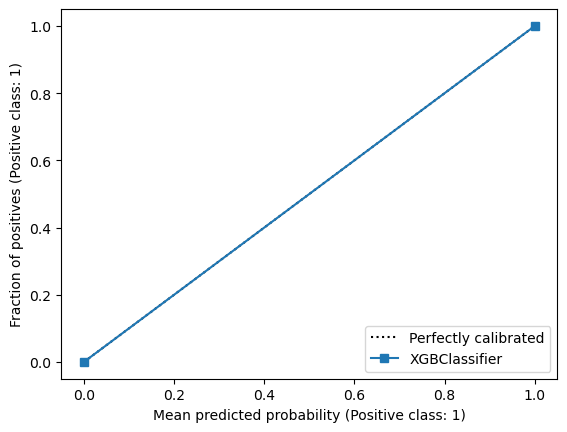

In [33]:
# обучим модель 
model_3 = XGBClassifier(random_state=SEED, eval_metric='logloss')
model_3.fit(X_train, y_train)

# замерим качество на тесте
y_pred = model_3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"accuracy: {accuracy:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"f1: {f1:.3f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_matrix}")

y_proba = model_3.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nroc_auc: {roc_auc:.3f}")

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

CalibrationDisplay.from_estimator(model_3, X_test, y_test)

In [35]:
data = pd.DataFrame()
data['target'] = y_test
data['prediction'] = model_3.predict_proba(X_test)[:, 1]

create_metrics_report(data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
1,0.5,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
2,0.6,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
3,0.7,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
4,0.8,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0


[0]	validation_0-logloss:0.64225
[10]	validation_0-logloss:0.33536
[20]	validation_0-logloss:0.18889
[30]	validation_0-logloss:0.11002
[40]	validation_0-logloss:0.06520
[50]	validation_0-logloss:0.03902
[60]	validation_0-logloss:0.02348
[70]	validation_0-logloss:0.01418
[80]	validation_0-logloss:0.00858
[90]	validation_0-logloss:0.00521
[99]	validation_0-logloss:0.00332
accuracy: 1.000
precision: 1.000
recall: 1.000
f1: 1.000
confusion matrix:
 [[20059     0]
 [    0 22906]]

roc_auc: 1.000


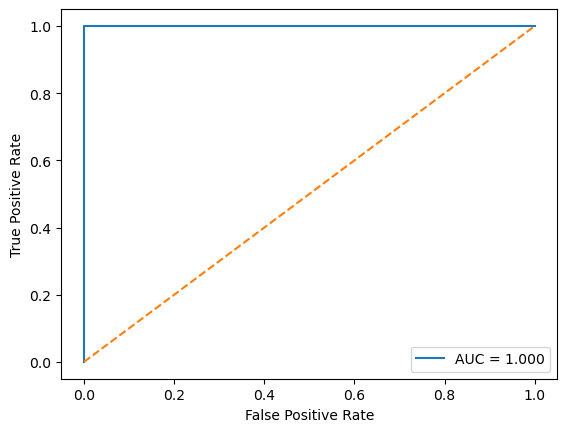

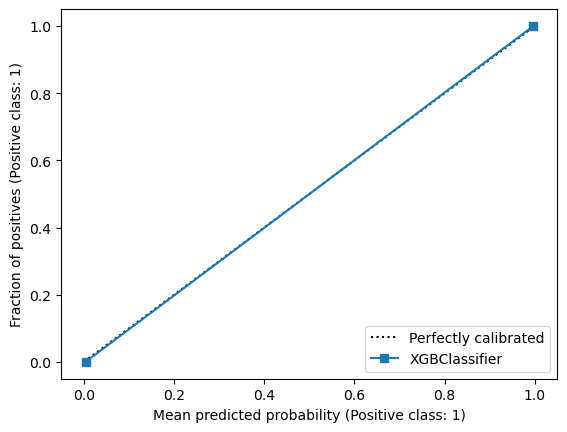

In [36]:
# обучим модель 
model_4 = XGBClassifier(
    random_state=SEED,
    eval_metric='logloss',
    max_depth=3,
    learning_rate=0.05,
    n_estimators=100,
    reg_alpha=0.1,
    subsample=0.8,
    early_stopping_rounds=20
)

model_4.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=10)

# замерим качество на тесте
y_pred = model_4.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"accuracy: {accuracy:.3f}")
print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"f1: {f1:.3f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_matrix}")

y_proba = model_4.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nroc_auc: {roc_auc:.3f}")

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

CalibrationDisplay.from_estimator(model_4, X_test, y_test)

In [37]:
data = pd.DataFrame()
data['target'] = y_test
data['prediction'] = model_4.predict_proba(X_test)[:, 1]

create_metrics_report(data)

,cut_off,roc_auc,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.4,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
1,0.5,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
2,0.6,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
3,0.7,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
4,0.8,1.0,1.0,1.0,1.0,1.0,22906,0,20059,0
